# Gold and Silver Ratio

### Overview
In this notebook, I will try to replicate the analysis performed by Belangp on his precious metal trading/stacking strategy based on the gold and silver ratio.

The actual code development hasn't been linear. I have gone back and forth to tweak some parameters to achieve the best alignment results.

### Reference
- GSR Valuation Update Time to Favor Silver (https://www.youtube.com/watch?v=C2EGjhcW-a0)

In [1]:
# Import libraries
import pandas as pd
import quandl
import math
import numpy as np
import scipy.stats
import statsmodels.api as sm
from matplotlib import pyplot as plt
from scipy.stats import linregress
import os
%matplotlib notebook

# Set up folder directories
input_dir = "01_Raw_Data/"
procs_dir = "02_Processed_Data/"
output_dir = "03_Output_Data/"

In [2]:
start_date = "1900-01-01"
end_date = "2020-08-25"

## 1. Prepare Price Data from Quandl
We are gonna leverage Quandl's free precious metal data for this analysis. Only run this module for periodic refresh as data are saved in the `\02_Processed_Data` folder.

#### Download Price Data for LBMA Gold
Uncomment the codes below to refresh the data.

In [14]:
# lbma_gold_df = quandl.get("LBMA/GOLD", authtoken="mph6fTrjas2wX3sBdYQn", start_date=start_date, end_date=end_date)
# lbma_gold_df['LBMA_Gold_USD'] = (lbma_gold_df['USD (AM)'] + lbma_gold_df['USD (PM)']) *0.5
# lbma_gold_df.index = pd.to_datetime(lbma_gold_df.index)
# pd.DataFrame(lbma_gold_df['LBMA_Gold_USD']).to_csv(procs_dir + 'lbma_gold_usd.csv')

#### Download Price Data for LBMA Silver
Uncomment the codes below to refresh the data.

In [13]:
# lbma_silver_df = quandl.get("LBMA/SILVER", authtoken="mph6fTrjas2wX3sBdYQn", start_date=start_date, end_date=end_date)
# lbma_silver_df.index = pd.to_datetime(lbma_silver_df.index)
# lbma_silver_df['LBMA_Silver_USD'] = lbma_silver_df['USD']
# pd.DataFrame(lbma_silver_df['LBMA_Silver_USD']).to_csv(procs_dir + 'lbma_silver_usd.csv')

#### Preprocess G&S Data
I append the downloaded gold and silver price data so that they're in the same dataframe.

In [5]:
# Read the downloaded data
lbma_gold_usd = pd.read_csv(procs_dir + 'lbma_gold_usd.csv', index_col=0, parse_dates=True)
lbma_silver_usd = pd.read_csv(procs_dir + 'lbma_silver_usd.csv', index_col=0, parse_dates=True)

# Resample to month-end (daily/weekly data will likely be too noisy)
lbma_gold_usd = lbma_gold_usd.resample('M').last()
lbma_silver_usd = lbma_silver_usd.resample('M').last()

# Append the gold and silver data
gs_comb_df = lbma_gold_usd.merge(lbma_silver_usd, how='outer', left_index=True, right_index=True)
gs_comb_df = gs_comb_df.dropna(how='any')

# Calculate Gold and Silver Ratio (GSR)
gs_comb_df['GSR'] = gs_comb_df['LBMA_Gold_USD'].divide(gs_comb_df['LBMA_Silver_USD'])

In [6]:
gs_comb_df.head()

,LBMA_Gold_USD,LBMA_Silver_USD,GSR
Date,,,
1968-04-30,39.100,2.397,16.312057
1968-05-31,41.975,2.483,16.904954
1968-06-30,40.925,2.502,16.356914
1968-07-31,38.875,2.285,17.013129
1968-08-31,39.825,2.239,17.786958


Good stuff. We have data available from 30/04/1968 for both gold and silver.

# 2. Calculate Periodic Return
For this analysis, we look at the horizon of every 10 years. For a rotational window of 10 years, we are going to do the following:
- Calculate return (both percentage and log) individually for gold and silver
- Calculate the return of silver relative to gold
- Append the GSR as at the **beginning** of each observation window

Since the data has been resampled to monthly, we will calculate the return every 120 months (i.e. 10 years).

In [7]:
# Calculate individual percentage return
gs_return_df = gs_comb_df[['LBMA_Gold_USD', 'LBMA_Silver_USD']].pct_change(periods=120).dropna()
gs_return_df.columns = ['return_gold', 'return_silver']

# Calculate silver return relative to gold 
gs_return_df['return_rel'] = gs_return_df['return_silver'] - gs_return_df['return_gold']

# Calculate individual log return
gs_log_return_df = np.log(gs_comb_df[['LBMA_Gold_USD', 'LBMA_Silver_USD']]).diff(periods=120).dropna()
gs_log_return_df.columns = ['log_return_gold', 'log_return_silver']

# Calculate silver return relative to gold 
gs_log_return_df['log_return_rel'] = gs_log_return_df['log_return_silver'] - gs_log_return_df['log_return_gold']

In [8]:
gs_return_df.head()
gs_log_return_df.head()

,log_return_gold,log_return_silver,log_return_rel
Date,,,
1978-04-30,1.472173,0.734820,-0.737353
1978-05-31,1.480711,0.789080,-0.691631
1978-06-30,1.498428,0.746267,-0.752161
1978-07-31,1.635839,0.891567,-0.744271
1978-08-31,1.653043,0.904339,-0.748704


Now for each 10 years' return of gold and silver, we need to append the GSR at the beginning of each observation window. Take, for instance, a 10-year observation window from **30/04/1968** to **30/04/1978** (inclusive):
- Gold YoY return = 335.87%, silver YoY return = 108.51%, relative YoY return = -227.36%
- GSR = 16.31 as at 30/04/1968

Note that the GSR on 30/04/1968, instead of 30/04/1978, is used here.

In [9]:
# Shift the column by 120 months backward, so that the GSR at the beginning of the 10-year observation window
# will be mapped to the observation window end date
gs_return_df['GSR_start'] = gs_comb_df['GSR'].shift(periods=120)
gs_return_df.head()

gs_log_return_df['GSR_start'] = gs_comb_df['GSR'].shift(periods=120)
gs_log_return_df.head()

,log_return_gold,log_return_silver,log_return_rel,GSR_start
Date,,,,
1978-04-30,1.472173,0.734820,-0.737353,16.312057
1978-05-31,1.480711,0.789080,-0.691631,16.904954
1978-06-30,1.498428,0.746267,-0.752161,16.356914
1978-07-31,1.635839,0.891567,-0.744271,17.013129
1978-08-31,1.653043,0.904339,-0.748704,17.786958


# 3. Perform Regression Analysis
Our data is now prepared and handsome, so we may proceed with our actual analysis.
## 3.1. Initial Attempt
#### Using Percentage Return

In [145]:
# Duplicate the df for the study
gs_return_df1 = gs_return_df

# Here x is GSR and y is the relative return
X1 = gs_return_df1['GSR_start']
Y1 = gs_return_df1['return_rel']

# Fit the line regression model
model1 = sm.OLS(Y1, sm.add_constant(X1))
results1 = model1.fit()
print(results1.summary())

# Prepare result text
ax1_text = "Pct_Return = {:.3f}*(GSR{:.3f})\nRSQ_Adj = {:.2f}%" \
            .format(results1.params.GSR_start, results1.params.const/results1.params.GSR_start,
                    results1.rsquared_adj*100)
print(ax1_text)

                            OLS Regression Results                            
Dep. Variable:             return_rel   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     310.9
Date:                Wed, 26 Aug 2020   Prob (F-statistic):           1.30e-54
Time:                        08:05:33   Log-Likelihood:                -791.35
No. Observations:                 509   AIC:                             1587.
Df Residuals:                     507   BIC:                             1595.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.9417      0.150    -19.645      0.0

C:\Users\jiape\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


#### Using Log Return

In [161]:
# Filter on the data (<= 2018-03-26)
# gs_return_df1 = gs_return_df.loc[gs_return_df.index <= "2018-02-01"]
gs_log_return_df1 = gs_log_return_df

# Here x is GSR and y is the relative return
X1b = gs_log_return_df1['GSR_start']
Y1b = gs_log_return_df1['log_return_rel']

# Fit the line regression model
model1b = sm.OLS(Y1b, sm.add_constant(X1b))
results1b = model1b.fit()
print(results1b.summary())

# Prepare result text
ax1b_text = "Log_Return = {:.3f}*(GSR{:.3f})\nRSQ_Adj = {:.2f}%" \
            .format(results1b.params.GSR_start, results1b.params.const/results1b.params.GSR_start,
                    results1b.rsquared_adj*100)
print(ax1b_text)

                            OLS Regression Results                            
Dep. Variable:         log_return_rel   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     873.0
Date:                Wed, 26 Aug 2020   Prob (F-statistic):          2.57e-112
Time:                        08:39:55   Log-Likelihood:                -1.9978
No. Observations:                 509   AIC:                             7.996
Df Residuals:                     507   BIC:                             16.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0835      0.032    -34.119      0.0

C:\Users\jiape\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


#### Analysis

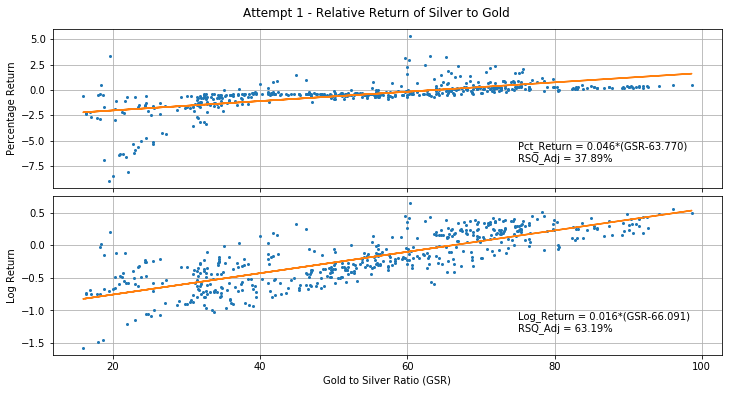

In [154]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Percentage return
ax1.plot(X1, Y1, 'o', markersize=2)
ax1.plot(X1, results1.params.GSR_start * X1 + results1.params.const)
ax1.set_ylabel('Percentage Return')
ax1.text(75, -5, ax1_text, verticalalignment="top")
ax1.grid()

# Log return
ax2.plot(X1b, Y1b, 'o', markersize=2)
ax2.plot(X1b, results1b.params.GSR_start * X1b + results1b.params.const)
ax2.set_xlabel('Gold to Silver Ratio (GSR)'), ax2.set_ylabel('Log Return')
ax2.text(75, -1, ax1b_text, verticalalignment="top")
ax2.grid()

fig.suptitle("Attempt 1 - Relative Return of Silver to Gold", y=0.93)
plt.subplots_adjust(hspace=.05)
plt.show()

From the comparison from above, we can see that using log return provides a better fitting results. This is not a surprise as it is a typical way to analyse time series data. Contrast our results to Balanp's:

%Return = 0.1654 \* (GSR - 64.1) = -10.602 + 0.1654 \* GSR, with RSQ = 82%

It appears that belangp calculated the return differently.

## 3.2. Second Attempt

In this attempt, I will apply a percentile filter to take out the extreme (1%) observations from both ends, using only the log return.

In [167]:
# Take out observations within 1% of either tails
filt_alpha = 0.01
filt_cond = ( gs_log_return_df.log_return_rel <= np.percentile(gs_log_return_df.log_return_rel, (1-filt_alpha)*100) ) &\
            ( gs_log_return_df.log_return_rel >= np.percentile(gs_log_return_df.log_return_rel, filt_alpha*100))
gs_log_return_df2 = gs_log_return_df[filt_cond]

# Here x is GSR and y is the relative return
X2 = gs_log_return_df2['GSR_start']
Y2 = gs_log_return_df2['log_return_rel']

# Fit the line regression model
model2 = sm.OLS(Y2, sm.add_constant(X2))
results2 = model2.fit()
print(results2.summary())

# Prepare result text
ax2_text = "Log_Return = {:.3f}*(GSR{:.3f})\nRSQ_Adj = {:.2f}%" \
            .format(results2.params.GSR_start, results2.params.const/results2.params.GSR_start,
                    results2.rsquared_adj*100)
print(ax2_text)

                            OLS Regression Results                            
Dep. Variable:         log_return_rel   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     794.4
Date:                Wed, 26 Aug 2020   Prob (F-statistic):          5.62e-105
Time:                        08:42:32   Log-Likelihood:                 17.119
No. Observations:                 497   AIC:                            -30.24
Df Residuals:                     495   BIC:                            -21.82
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0381      0.032    -32.788      0.0

C:\Users\jiape\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


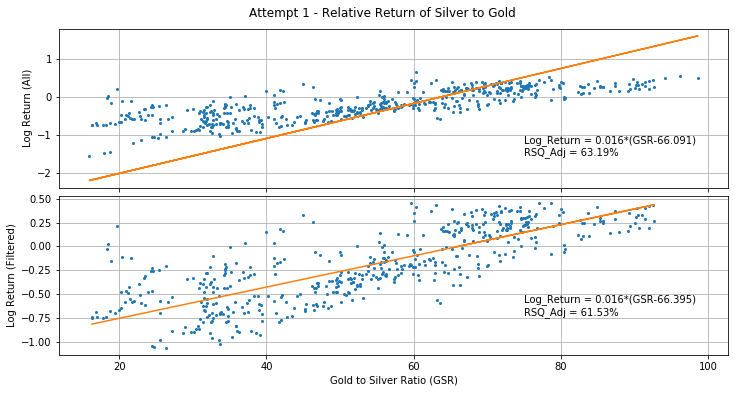

In [165]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Percentage return
ax1.plot(X1b, Y1b, 'o', markersize=2)
ax1.plot(X1b, results1.params.GSR_start * X1 + results1.params.const)
ax1.set_ylabel('Log Return (All)')
ax1.text(75, -1, ax1b_text, verticalalignment="top")
ax1.grid()

# Log return
ax2.plot(X2, Y2, 'o', markersize=2)
ax2.plot(X2, results1b.params.GSR_start * X2 + results1b.params.const)
ax2.set_xlabel('Gold to Silver Ratio (GSR)'), ax2.set_ylabel('Log Return (Filtered)')
ax2.text(75, -0.5, ax2_text, verticalalignment="top")
ax2.grid()

fig.suptitle("Attempt 1 - Relative Return of Silver to Gold", y=0.93)
plt.subplots_adjust(hspace=.05)
plt.show()